# Forecasting with ARIMA

In [1]:
from pandas import read_csv, DataFrame
from datetime import datetime, timedelta
from pmdarima import auto_arima, ARIMA, metrics
import numpy as np
from matplotlib.pyplot import figure


## Reading the dataset.

We read the dataset. Since we're dealing with time series it is useful to convert the first column to Python's built-in `datetime` data type.

Index(['price_eurusd', 'open_eurusd', 'high_eurusd', 'low_eurusd',
       'change_eurusd', 'bid', 'price_sp500', 'open_sp500', 'high_sp500',
       'low_sp500', 'change_sp500'],
      dtype='object')


<AxesSubplot:title={'center':'Evolución del precio del dólar en colones'}, xlabel='date', ylabel='CRC'>

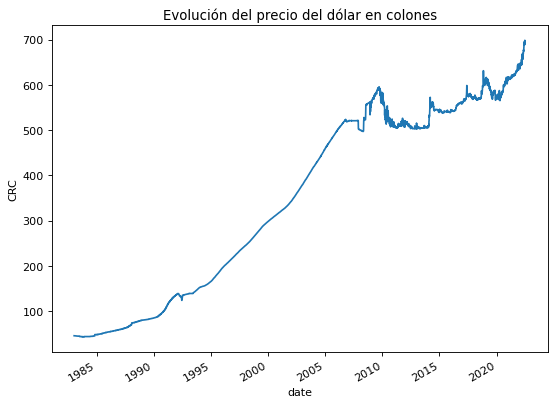

In [5]:
data = read_csv('full_dataset.csv', header=0, parse_dates=[0], index_col=0, date_parser= lambda x: datetime.strptime(x, '%m/%d/%Y')).drop(['ask'], axis=1)
print(data.columns)
figure(figsize=(8, 6), dpi=80)
data['bid'].plot(ylabel='CRC', title="Evolución del precio del dólar en colones")


## ARIMA model definition

To create the model, we need the `p`, `d`, and `q`, parameters, which control different parts of the algorithm. The `pmdarima` package provides the `auto_arima` method which automates this process.
To do this, the method first finds the `d` parameter through stationarity tests. It then uses this parameter to approximate the `p` and `q` using the Aikake's Information Criterion (AIC), a criterion used to compare multiple models.

In [ ]:
model = auto_arima(data['bid'], m=12, seasonal=True, start_p=0, start_q=0, max_order=4, test='adf', stepwise=True, trace=True)

Once we have the `p`, `d`, and `q` values it is useful to save them, as running the `auto_arima` can take a while.
If we have the parameters, we can use the `ARIMA` method to create a model.

In [6]:
model = ARIMA(order=(4, 1, 3), seasonal_order=(2,0,1,12))
model.fit(data['bid'])

c:\Users\chris\miniconda3\envs\agvd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chris\miniconda3\envs\agvd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chris\miniconda3\envs\agvd\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(4, 1, 3), seasonal_order=(2, 0, 1, 12))

In [7]:
model.aic()

27111.137129403716

## Forecast data
Once we have created and trained our model we can create forecasts using the `predict` method. We recommend using the `return_conf_int` because it helps to estimate how useful is the prediction. 

In [9]:
forecast = model.predict(n_periods=18, return_conf_int=True)

### Forecast evaluation

We now create a test to see how the error grows as the lenght of time between the last observation and the prediction grows.

In [17]:
def forecast_error(days, true_values, predicted_values):
    error_values = []
    for i in range(1, days + 1):
        error_values.append(metrics.smape(true_values[:i], predicted_values[:i]))
    return error_values

def create_date_series(start_date, days):
    day = datetime.strptime(start_date, "%Y-%m-%d")
    dates = []
    for i in range(days):
        dates.append(day + timedelta(days=i))
    return np.array(dates, dtype='datetime64[s]')


dates = create_date_series('2022-07-02', 18)

forecast_df = DataFrame(data=forecast[0], index=dates, columns=['bid'])
forecast_df.index.name = 'date'

new_data = read_csv('current_data.csv', header=0, parse_dates=[0], index_col=0, date_parser= lambda x: datetime.strptime(x, '%d-%b-%y'))

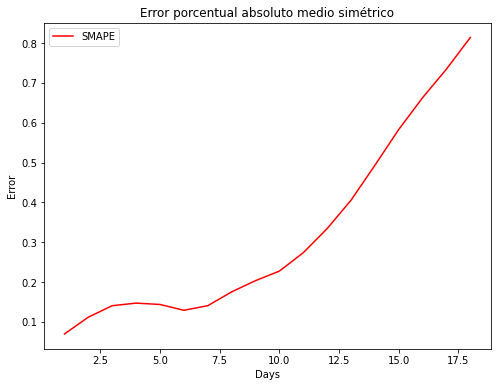

In [18]:
errors = forecast_error(18, new_data['bid'].to_numpy(), forecast[0])
days = [i for i in range(1, 19)]
error_df = DataFrame(data=errors, index=days, columns=['SMAPE'])
error_df.index.namy = 'Days'
error_df.plot(ls='-', color='r', xlabel='Days', ylabel='Error', figsize=(8, 6), title="Error porcentual absoluto medio simétrico").figure.savefig("smape.jpg")

### Visual comparison

Finally we compare the forecast with the real data. As we can see, the difference between the upper and lower bound keeps growing. This is why it is important to keep updating the model.

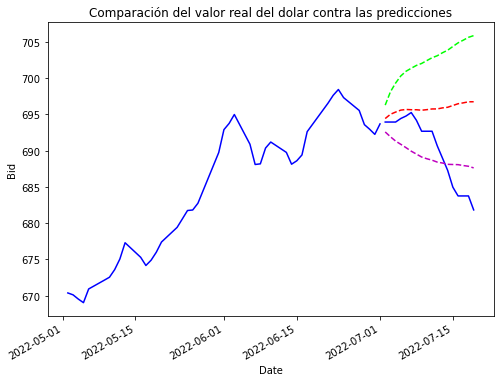

In [19]:
lower_bounds = []
upper_bounds = []

for bounds in forecast[1]:
    lower_bounds.append(bounds[0])
    upper_bounds.append(bounds[1])

lower_df = DataFrame(data=lower_bounds, index=dates, columns=['bid'])
upper_df = DataFrame(data=upper_bounds, index=dates, columns=['bid'])
lower_df.index.name = 'date'
upper_df.index.name = 'date'

data['2022-05-01' : '2022-07-01']['bid'].plot(ls="-", color="b", ylabel='Bid', title="Comparación del valor real del dolar contra las predicciones")
forecast_df['bid'].plot(ls="--", color="r")
new_data['bid'].plot(ls='-', color='b')
lower_df['bid'].plot(ls='--', color='m')
upper_df['bid'].plot(ls='--', color='lime', xlabel="Date", figsize=(8, 6)).figure.savefig("arima.jpg")